# Gillespie Simulation

This is the jupyter notebook version of the simulation.

- The code is written to accomodate networks of different sizes (i.e. multiple miRNAs, transcription factors etc.)
- In its current form it can easily be rewritten to receive input from a graphical user interface in the shape of a csv file or array which is then converted into a data frame such that the relevant information about linked molecules (e.g. mRNA to encoded protein) can be extracted
- Currently, the simulation loops through a preexisting nd array, later versions are planned to append a new row for each iteration to fit in with Alain's code which allows interrupting the simulation b



In [157]:
# Import supporting packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1)

In [214]:
### dataframe construction

parameter_types = ["Name", "Type", "Amount", "alpha", "beta", "pi", "mu", "K", "mRNA -> protein", "corr_TF", "corr_RNA_dup"]
data_type = {"mRNA" : 0, "protein" : 1, "miRNA" : 2, "RNA-duplex" : 3}

par_T = ["tf_mRNA", "mRNA", 40, 15, None, 10, 15, None, "TF", None, None]
par_Q = ["TF", "protein", 20, None, None, None, 8, None, None, None]
par_S = ["miRNA", "miRNA", 13, 18, 4, None, 0.5, 4, None, "TF", "C"]
par_R = ["target_mRNA", "mRNA", 30, 12, None, 10, 6, 3, "TARGET", "TF", "C"]
par_P = ["TARGET", "protein", 15, None, None, None, 7, None, None, None]
par_C = ["C", "RNA_duplex", 0, None, None, None, 5, None, None, None, None]

"""

par_1 = ["C2", "RNA_duplex", 0, None, None, None, 2, None, None, None, None]
par_2 = ["miRNA", "miRNA", 25, 5, 0.8, None, 0.1, 5, None, "TF", "C2"]
par_3 = ["target_mRNA", "mRNA", 5, 3, None, 2, 0.1, 2, "TARGET2", "TF", "C2"]
par_4 = ["TARGET2", "protein", 40, None, None, None, 0.1, None, None, None]

"""

data = pd.DataFrame([par_T, par_Q, par_S, par_R, par_P, par_C], columns = parameter_types)

### data = pd.DataFrame([par_T, par_Q, par_S, par_R, par_P, par_C, par_1, par_2, par_3, par_4], columns = parameter_types)

data = data.fillna(0)

molecules= data.pop("Name").to_numpy()
#molecules = np.array(molecules)

data_indexed = data.copy()

data_indexed.index = molecules
print(data_indexed)

                   Type  Amount  alpha  beta    pi    mu    K mRNA -> protein  \
tf_mRNA            mRNA      40   15.0   0.0  10.0  15.0  0.0              TF   
TF              protein      20    0.0   0.0   0.0   8.0  0.0               0   
miRNA             miRNA      13   18.0   4.0   0.0   0.5  4.0               0   
target_mRNA        mRNA      30   12.0   0.0  10.0   6.0  3.0          TARGET   
TARGET          protein      15    0.0   0.0   0.0   7.0  0.0               0   
C            RNA_duplex       0    0.0   0.0   0.0   5.0  0.0               0   

            corr_TF corr_RNA_dup  
tf_mRNA           0            0  
TF                0            0  
miRNA            TF            C  
target_mRNA      TF            C  
TARGET            0            0  
C                 0            0  


In [215]:
### get parameter array
parameters = data_indexed.to_numpy()[:,2:6]
print("parameters: \n", parameters)



complex_names = data_indexed.index[data.Type =="RNA_duplex"].tolist()
print(complex_names)


duplexes = {}
miRNA_dict = {}

miRNA = data.loc[data.Type == "miRNA"]
mRNA = data.loc[data.Type == "mRNA"]

print("miRNA: \n:", miRNA)

for c in complex_names:
    duplexes[c] = data.index[data.corr_RNA_dup==c]
    miRNA_index = np.array(miRNA.index[miRNA.corr_RNA_dup==c])[0]
    mRNA_index = np.array( mRNA.index[mRNA.corr_RNA_dup ==c])[0]
    miRNA_dict[miRNA_index] = [mRNA_index, data_indexed.index.get_loc(c)]

TF_reg = data.index[data.corr_TF != 0].tolist()
TF_dict = {}

for t in TF_reg:
    
    TF_dict[t] = [data_indexed.index.get_loc(data.loc[t, "corr_TF"]), data.loc[t, "K"]]

print(TF_dict)


print(TF_reg)
    
    
print("duplexes:\n", duplexes)

print("miRNA_dict: \n", miRNA_dict)


### get initial values
initial_values = data_indexed.to_numpy()[:,1]
print("initial values: \n", initial_values, len(initial_values))


parameters: 
 [[15.0 0.0 10.0 15.0]
 [0.0 0.0 0.0 8.0]
 [18.0 4.0 0.0 0.5]
 [12.0 0.0 10.0 6.0]
 [0.0 0.0 0.0 7.0]
 [0.0 0.0 0.0 5.0]]
['C']
miRNA: 
:     Type  Amount  alpha  beta   pi   mu    K mRNA -> protein corr_TF  \
2  miRNA      13   18.0   4.0  0.0  0.5  4.0               0      TF   

  corr_RNA_dup  
2            C  
{2: [1, 4.0], 3: [1, 3.0]}
[2, 3]
duplexes:
 {'C': Index([2, 3], dtype='int64')}
miRNA_dict: 
 {2: [3, 5]}
initial values: 
 [40 20 13 30 15 0] 6


In [216]:
genes_dict = {}

for m in mRNA.index:
    protein_name = mRNA.loc[m, "mRNA -> protein"]
    protein_index = data_indexed.index.get_loc(protein_name)
    genes_dict[m] = protein_index

print(genes_dict)

{0: 1, 3: 4}


In [217]:
# Set meta-parameters
trajectories = 100  # Number of trajectories to simulate
steps = 100          # Number of steps per trajectory

In [218]:
## molecule number array
N = np.zeros([len(molecules), trajectories, steps+1])
T = np.zeros([trajectories, steps+1])

print(N.shape)

(6, 100, 101)


In [219]:
def transcription(molecule, i, j):
    N[molecule,i,j+1] +=1
    
def translation(molecule, i, j):
    ### determine corresponding protein
    protein = genes_dict[molecule]
    ### update protein count
    N[protein,i,j+1] +=1
    
def degradation(molecule, i, j):
    N[molecule,i,j+1]-=1
    
def complex_association(miRNA, i, j):
    ### miRNA corresponds to molecule
    
    ### determine mRNA and duplex from dict
    mRNA, duplex = miRNA_dict[miRNA]
    
    N[mRNA,i,j+1] -= 1
    N[miRNA,i,j+1] -= 1
    N[duplex,i,j+1] += 1

def complex_dissociation(r_mol, duplex, i, j):

    ### determine miRNA from duplex

    miRNA = duplexes[r_mol][0]
    
    N[miRNA,i,j+1] += 1
    N[duplex,i,j+1] -= 1    


In [220]:
print(miRNA_dict)

{2: [3, 5]}


OBJECTIVE: find algorithm that chooses reation and finds type of reaction based on matrix column

- step 1 determine reaction probabilities based on constant rates and current number of molecules
- step 2 generate second instance of reaction probabilities array but flattened
- step 3 use numpy random choice to determine reaction (some reactions are not real but have probability 0)
- step 4 determine index based on % and // operators
- step 5 determine molecule and reaction type based on index
- step 6 execute function for corresponding reaction type on corresponding molecule

In [221]:
# Loop over trajectories
for i in range(trajectories):
    N[:,i,0] = initial_values

    print("TRAJECTORY ", i)
    print(" ")
        
    for j in range(steps):

        for molecule in range(len(molecules)):
            N[molecule,i,j+1] = N[molecule,i,j]
    
        
        ### update transcription factor based reaction rates

        for key in TF_dict:
            TF = TF_dict[key][0]
            K = TF_dict[key][1]
            parameters[key, 0] *= (N[TF,i,j]/(N[TF,i,j]+K))

        ### include mRNA count in reaction rate for complex assembly

        par_modified = np.copy(parameters)

        for m in miRNA.index:
            index_mRNA = miRNA_dict[m][0]
            
            par_modified[m, 1] *= N[index_mRNA, i, j]

        ### calculate total reaction rate

        N_current = N[:,i,j]  
        reactions = np.multiply(N_current, par_modified.T)

        R_tot = reactions.sum()

        p_reactions = reactions/R_tot  

        isnan = np.isnan(p_reactions.tolist())

        if np.any(isnan): 
            print("P contains NaN:", p_reactions, "\n")
            print("parameters: ", parameters)
            print("N: ", N_current)
                
        ### Determine time to next reaction
        
        u = np.random.random()
        t = 1/R_tot * np.log(1/u)
        T[i,j+1] = T[i,j] + t

        ### Select the next reaction:
        u = np.random.random()
        next_reaction = np.random.choice(np.arange(len(p_reactions.flatten())), p=p_reactions.flatten().tolist())
        
        
        reaction_types = ["transcription", "complex assembly", "translation", "degradation"]

        r_type = reaction_types[next_reaction//len(molecules)]
        r_mol = molecules[next_reaction%len(molecules)]

        print(r_type + " of " + r_mol)
        

        ### execute selected reaction
     
        if next_reaction//len(molecules) == 0:
            transcription(next_reaction%len(molecules), i, j)
        elif next_reaction//len(molecules) == 1:
            complex_association(next_reaction%len(molecules), i, j)
        elif next_reaction//len(molecules) == 2:
            translation(next_reaction%len(molecules), i, j)
            
        elif next_reaction//len(molecules) == 3:
            r_type = data.loc[next_reaction%len(molecules), "Type"]
            if r_mol == "RNA_duplex": 
                complex_dissociation(r_mol, duplex, i, j)

            else:
                degradation(next_reaction%len(molecules),i,j)   
    print(" ")

TRAJECTORY  0
 
complex assembly of miRNA
degradation of miRNA
complex assembly of miRNA
degradation of tf_mRNA
translation of target_mRNA
degradation of TF
complex assembly of miRNA
transcription of tf_mRNA
transcription of tf_mRNA
transcription of tf_mRNA
complex assembly of miRNA
complex assembly of miRNA
translation of tf_mRNA
transcription of tf_mRNA
degradation of target_mRNA
complex assembly of miRNA
degradation of TF
degradation of TF
degradation of tf_mRNA
degradation of TF
degradation of tf_mRNA
translation of target_mRNA
translation of tf_mRNA
transcription of tf_mRNA
translation of tf_mRNA
translation of tf_mRNA
translation of tf_mRNA
degradation of C
transcription of tf_mRNA
transcription of tf_mRNA
complex assembly of miRNA
complex assembly of miRNA
complex assembly of miRNA
degradation of tf_mRNA
degradation of TF
degradation of tf_mRNA
degradation of TF
complex assembly of miRNA
degradation of tf_mRNA
degradation of C
translation of target_mRNA
degradation of TARGET
tra

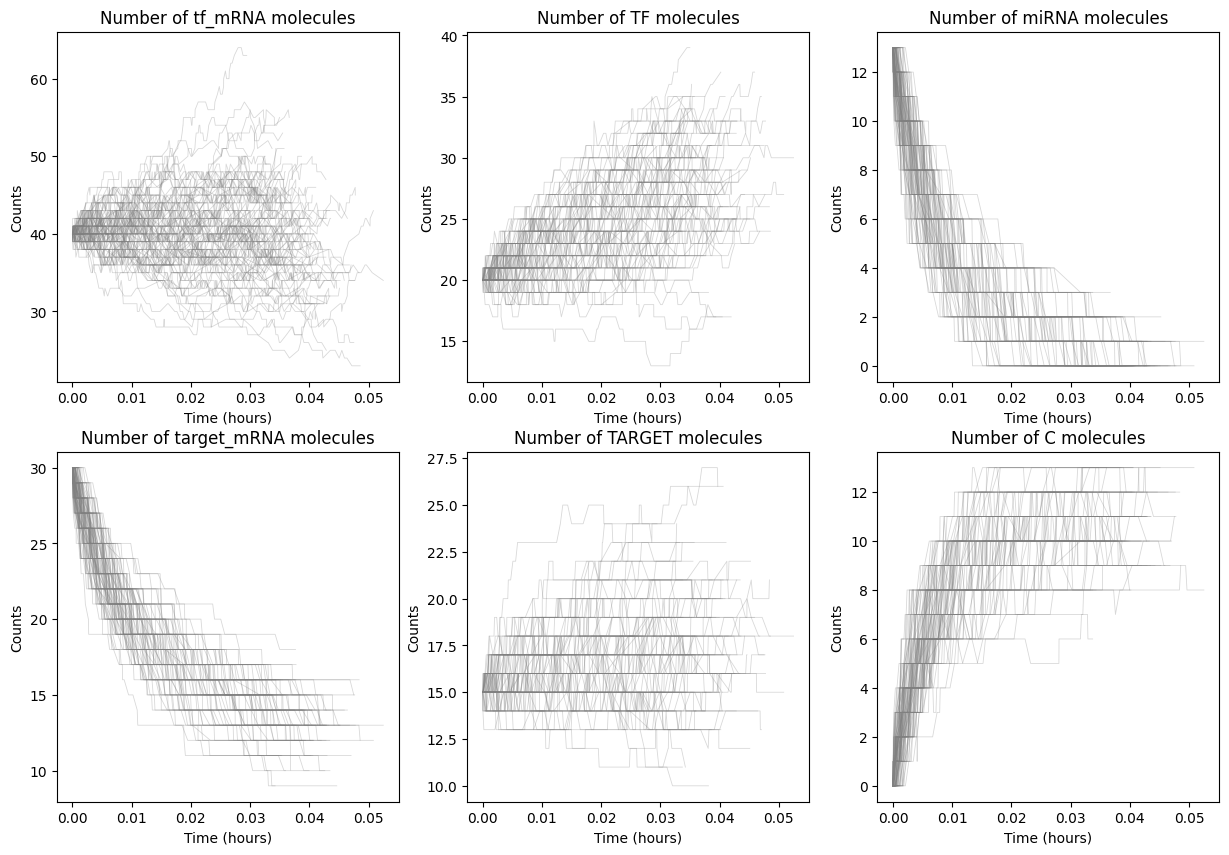

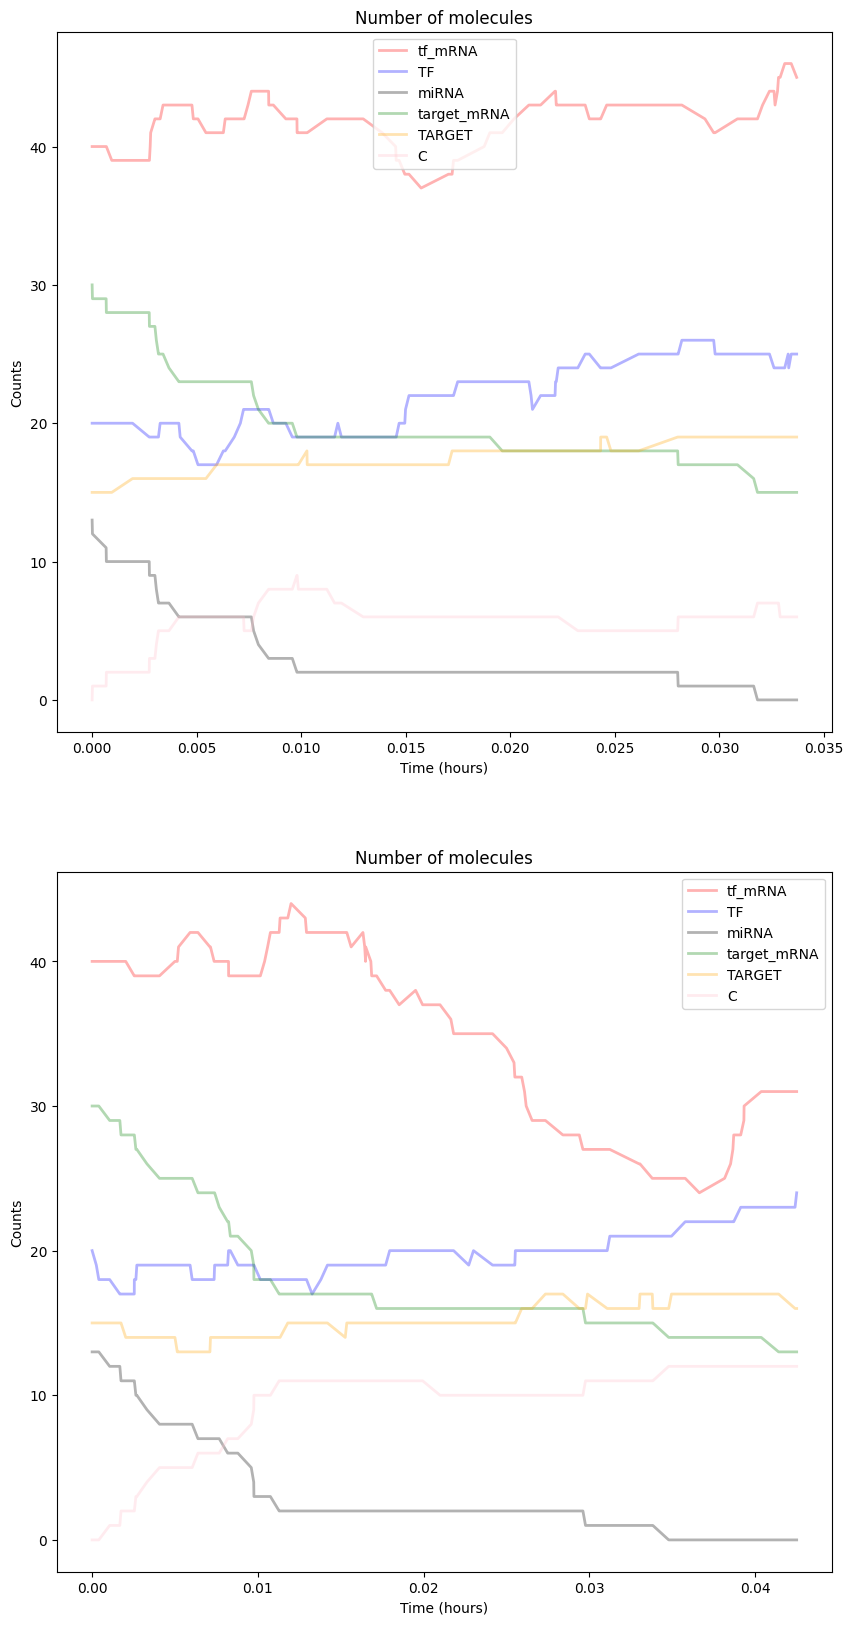

In [222]:
k=0

# Plot the simulated trajectories for each molecule type
fig, axs = plt.subplots(2, 3, figsize=(15,10))
for i in range(2):
    for j in range(3):
        axs[i][j].set_title(f'Number of {molecules[k]} molecules')
        axs[i][j].set_xlabel("Time (hours)")
        axs[i][j].set_ylabel("Counts")
        k+=1

    
# Plot each simulated trajectory
for i in range(trajectories):
    axs[0][0].plot(T[i,:], N[0,i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    axs[0][1].plot(T[i,:], N[1,i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    axs[0][2].plot(T[i,:], N[2,i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    axs[1][0].plot(T[i,:], N[3,i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    axs[1][1].plot(T[i,:], N[4,i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    axs[1][2].plot(T[i,:], N[5,i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)


plt.show()

# Let's also plot a few simulations
n2plot = 2
is2plot = np.random.choice(list(range(trajectories)), size=n2plot, replace=False)
fig, axs = plt.subplots(n2plot, 1, figsize=(10,20))

for i in range(n2plot):
    axs[i].set_title(f'Number of molecules')
    axs[i].set_xlabel("Time (hours)")
    axs[i].set_ylabel("Counts")
    axs[i].plot(T[i,:], N[0,i,:], marker='', color='red', linewidth=2.0, alpha=0.3)
    axs[i].plot(T[i,:], N[1,i,:], marker='', color='blue', linewidth=2.0, alpha=0.3)
    axs[i].plot(T[i,:], N[2,i,:], marker='', color='black', linewidth=2.0, alpha=0.3)
    axs[i].plot(T[i,:], N[3,i,:], marker='', color='green', linewidth=2.0, alpha=0.3)
    axs[i].plot(T[i,:], N[4,i,:], marker='', color='orange', linewidth=2.0, alpha=0.3)
    axs[i].plot(T[i,:], N[5,i,:], marker='', color='pink', linewidth=2.0, alpha=0.3)
    axs[i].legend(molecules)
plt.show()